In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

### Data Preparation 

In [2]:
preprocessed_output_data_path = "../data/output"

In [3]:
# Load datasets 
train = pd.read_csv(f"{preprocessed_output_data_path}/train_fe.csv")
test = pd.read_csv(f"{preprocessed_output_data_path}/test_fe.csv")

In [4]:
#Create target classification variable 
def classify_etr(etr):
    if etr > 0.25:
        return 0   # Low Tax Avoidance
    elif 0.25 >= etr > 0.15:
        return 1   # Medium Tax Avoidance
    else:
        return 2   # High Tax Avoidance

In [5]:
train["ETR_class"] = train["etr"].apply(classify_etr)
test["ETR_class"] = test["etr"].apply(classify_etr)

In [6]:
#Check class balance
class_counts = train["ETR_class"].value_counts().sort_index()
print("\nClass distribution:")
print(class_counts)


Class distribution:
ETR_class
0    1267
1    1668
2    1058
Name: count, dtype: int64


C:\Users\agata\AppData\Local\Temp\ipykernel_37112\396506651.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="ETR_class", data=train, palette="viridis")


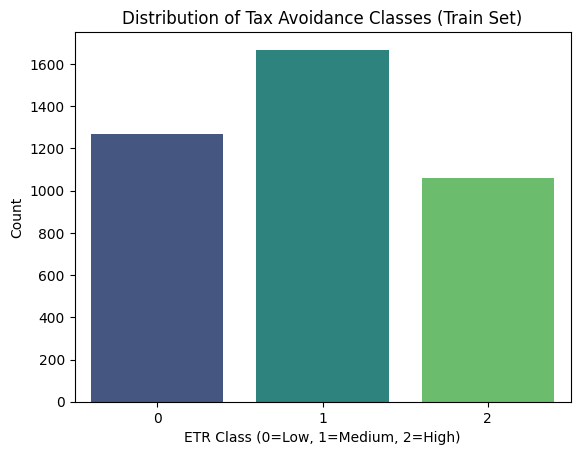

In [7]:
#Visualize distribution 
sns.countplot(x="ETR_class", data=train, palette="viridis")
plt.title("Distribution of Tax Avoidance Classes (Train Set)")
plt.xlabel("ETR Class (0=Low, 1=Medium, 2=High)")
plt.ylabel("Count")
plt.show()

### Select features


Top 20 Selected Features:
                     Feature  RF_Importance  MI_Score
15                       etr       0.364370  1.079435
98                etr_y_past       0.062887  0.290958
99                  etr_y_ma       0.052833  0.285647
16                      diff       0.031594  0.167341
100                  diff_ma       0.022977  0.178037
33                  WB_GDPpc       0.016881  0.098767
2                        txt       0.016452  0.171953
4                        str       0.012246  0.133236
3                         pi       0.011522  0.163779
89                  roa_clip       0.011409  0.132526
64   str_cat_(0.0875, 0.192]       0.011261  0.083930
17                       roa       0.011218  0.131983
71               intant_sqrt       0.010508  0.164015
8                     intant       0.010237  0.163793
6                         ni       0.010056  0.165031
101                   roa_ma       0.009341  0.128235
12                   revenue       0.009268  0.136131
2

C:\Users\agata\AppData\Local\Temp\ipykernel_37112\898253596.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


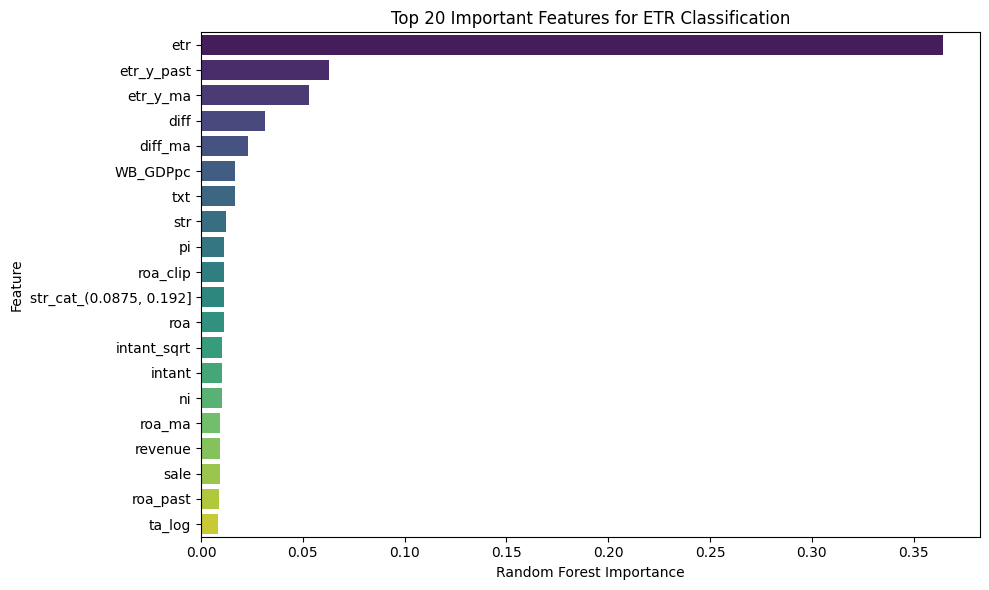

In [8]:
#  Prepare feature matrix 
# Drop non-feature columns
drop_cols = ["ETR", "ETR_class"]
id_cols = [c for c in train.columns if "firm" in c.lower() or "id" in c.lower() or "name" in c.lower() or "year" in c.lower()]
drop_cols.extend(id_cols)
drop_cols = list(set(drop_cols))

# Keep only numeric features
X = train.drop(columns=drop_cols, errors="ignore")
X = X.select_dtypes(include=["number"]) 
y = train["ETR_class"]

# Compute feature importance using Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Compute Mutual Information as validation
mi = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Combine both rankings
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "RF_Importance": rf.feature_importances_,
    "MI_Score": mi
}).sort_values(by="RF_Importance", ascending=False)

#  Select top 20 features
top_n = 20
top_features = feature_importance_df.head(top_n)
selected_feature_names = top_features["Feature"].tolist()

print("\nTop 20 Selected Features:")
print(top_features)

# Visualization 
plt.figure(figsize=(10, 6))
sns.barplot(
    x="RF_Importance",
    y="Feature",
    data=top_features,
    palette="viridis"
)
plt.title("Top 20 Important Features for ETR Classification")
plt.xlabel("Random Forest Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Model Training

In [9]:
# Time-series cross-validation
#  'year' column, used for ordering
if "year" in train.columns:
    sorted_idx = np.argsort(train["year"].values)
    X = X.iloc[sorted_idx]
    y = y.iloc[sorted_idx]

tscv = TimeSeriesSplit(n_splits=5)

# Define models and parameter grids
models = {
    "Logistic Regression": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(multi_class="multinomial", max_iter=500))
        ]),
        "params": {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l2"]
        }
    },
    "K-Nearest Neighbors": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier())
        ]),
        "params": {
            "clf__n_neighbors": [3, 5, 7, 9, 11],
            "clf__weights": ["uniform", "distance"]
        }
    },
    "Support Vector Classifier": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(decision_function_shape="ovr"))
        ]),
        "params": {
            "clf__C": [0.1, 1, 10],
            "clf__kernel": ["linear", "rbf"],
            "clf__gamma": ["scale", "auto"]
        }
    }
}

# Train and evaluate models
results = []

for model_name, cfg in models.items():
    print(f"\n Training {model_name}")
    grid = GridSearchCV(
        estimator=cfg["pipeline"],
        param_grid=cfg["params"],
        cv=tscv,
        scoring={"accuracy": "accuracy", "f1_macro": "f1_macro"},
        refit="f1_macro",        
        n_jobs=-1,
        return_train_score=False
    )
    grid.fit(X, y)

    best_model   = grid.best_estimator_
    best_params  = grid.best_params_
    best_f1      = grid.cv_results_["mean_test_f1_macro"][grid.best_index_]
    best_acc     = grid.cv_results_["mean_test_accuracy"][grid.best_index_]

    print(f" Best CV Macro F1 for {model_name}: {best_f1:.4f}")
    print(f"   Corresponding CV Accuracy: {best_acc:.4f}")
    #print(f"   Best Parameters: {best_params}")

    results.append({
        "Model": model_name,
        "Best Macro F1 (CV)": best_f1,
        "Best Accuracy (CV)": best_acc,
        "Best Params": best_params
    })

#Summary & best-by-Macro-F1 selection
results_df = (pd.DataFrame(results)
              .sort_values(by="Best Macro F1 (CV)", ascending=False)
              .reset_index(drop=True))

print("\n Model Comparison (ranked by Macro F1)")
print(results_df)

best_model_name = results_df.loc[0, "Model"]
print(f"\n Best model by Macro F1: {best_model_name}")




 Training Logistic Regression


c:\Users\agata\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 Best CV Macro F1 for Logistic Regression: 0.9338
   Corresponding CV Accuracy: 0.9326

 Training K-Nearest Neighbors
 Best CV Macro F1 for K-Nearest Neighbors: 0.5288
   Corresponding CV Accuracy: 0.5606

 Training Support Vector Classifier
 Best CV Macro F1 for Support Vector Classifier: 0.9278
   Corresponding CV Accuracy: 0.9272

 Model Comparison (ranked by Macro F1)
                       Model  Best Macro F1 (CV)  Best Accuracy (CV)  \
0        Logistic Regression            0.933832            0.932632   
1  Support Vector Classifier            0.927826            0.927218   
2        K-Nearest Neighbors            0.528808            0.560602   

                                         Best Params  
0               {'clf__C': 10, 'clf__penalty': 'l2'}  
1  {'clf__C': 1, 'clf__gamma': 'scale', 'clf__ker...  
2  {'clf__n_neighbors': 11, 'clf__weights': 'dist...  

 Best model by Macro F1: Logistic Regression


In [10]:
results_df.to_csv("classification_model_results.csv", index=False)

### Final evaluation

 Best model selected based on CV (Best Macro F1 (CV)): Logistic Regression
   CV Macro F1: 0.9338
   CV Accuracy: 0.9326


c:\Users\agata\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



 Test Accuracy: 0.9421

Classification Report:
              precision    recall  f1-score   support

         Low     0.9505    0.9320    0.9412       103
      Medium     0.9439    0.9487    0.9463       195
        High     0.9242    0.9385    0.9313        65

    accuracy                         0.9421       363
   macro avg     0.9395    0.9397    0.9396       363
weighted avg     0.9422    0.9421    0.9422       363



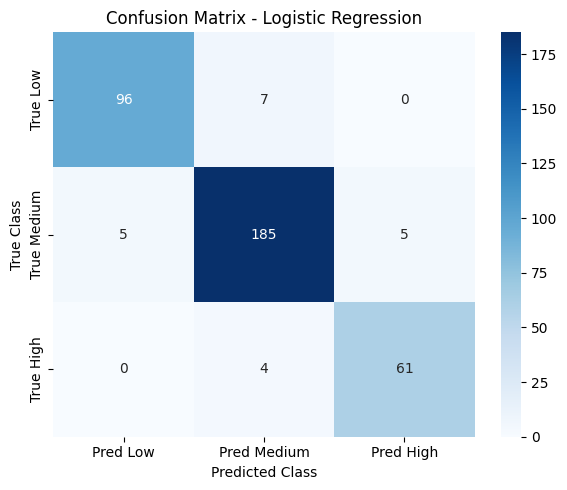

In [11]:
import ast
from sklearn.metrics import confusion_matrix

# Load CV results and pick the best row by Macro F1
results = pd.read_csv("classification_model_results.csv")
metric_col = "Best Macro F1 (CV)" if "Best Macro F1 (CV)" in results.columns else "Best Accuracy (CV)"
results = results.sort_values(by=metric_col, ascending=False).reset_index(drop=True)

best_model_name = results.loc[0, "Model"]
best_params_raw = results.loc[0, "Best Params"]
best_macro_f1 = results.loc[0, "Best Macro F1 (CV)"] if "Best Macro F1 (CV)" in results.columns else None
best_acc_cv = results.loc[0, "Best Accuracy (CV)"] if "Best Accuracy (CV)" in results.columns else None

print(f" Best model selected based on CV ({metric_col}): {best_model_name}")
if best_macro_f1 is not None:
    print(f"   CV Macro F1: {best_macro_f1:.4f}")
if best_acc_cv is not None:
    print(f"   CV Accuracy: {best_acc_cv:.4f}")

# Parse the param dict
try:
    best_params = ast.literal_eval(best_params_raw) if isinstance(best_params_raw, str) else best_params_raw
except Exception:
    best_params = {}

# Build the pipeline skeleton matching training step
if best_model_name == "Logistic Regression":
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=42))
    ])
elif best_model_name == "K-Nearest Neighbors":
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier())
    ])
elif best_model_name == "Support Vector Classifier":
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(decision_function_shape="ovr", probability=False, random_state=42))
    ])
else:
    raise ValueError(f"Unknown model name: {best_model_name}")

# Apply tuned hyperparameters if present 
if isinstance(best_params, dict) and best_params:
    try:
        pipeline.set_params(**best_params)
    except ValueError as e:
        print("  Using defaults params")
        print(e)

drop_cols = ["ETR", "ETR_class"]
id_cols = [c for c in train.columns
           if any(k in c.lower() for k in ["firm", "id", "name", "year", "ticker"])]
drop_cols = list(set(drop_cols + id_cols))

X_train = train.drop(columns=drop_cols, errors="ignore").select_dtypes(include=["number"]).copy()
y_train = train["ETR_class"].copy()

feature_cols = X_train.columns.tolist()

X_test = test.drop(columns=drop_cols, errors="ignore").select_dtypes(include=["number"]).copy()
X_test = X_test.reindex(columns=feature_cols)
X_test = X_test.fillna(0.0)

y_test = test["ETR_class"].copy()
# Fit on full training data
pipeline.fit(X_train, y_train)

# Evaluate on test set 
y_pred = pipeline.predict(X_test)

labels = [0, 1, 2]
target_names = ["Low", "Medium", "High"]

acc = accuracy_score(y_test, y_pred)
print(f"\n Test Accuracy: {acc:.4f}\n")

report = classification_report(y_test, y_pred, labels=labels, target_names=target_names, digits=4)
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=[f"True {t}" for t in target_names],
                        columns=[f"Pred {t}" for t in target_names])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()


cm_df.to_csv("confusion_matrix.csv")

Logistic Regression performs excellently with ~0.94 accuracy and macro F1, indicating balanced performance across all classes. The confusion matrix shows most errors are between Low and Medium, with very few Medium-to-High misclassifications and strong recall for High (no High predicted as Low).

### Summary of 3 models

c:\Users\agata\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Results:
              precision    recall  f1-score   support

         Low       0.95      0.93      0.94       103
      Medium       0.94      0.96      0.95       195
        High       0.95      0.91      0.93        65

    accuracy                           0.94       363
   macro avg       0.95      0.93      0.94       363
weighted avg       0.94      0.94      0.94       363



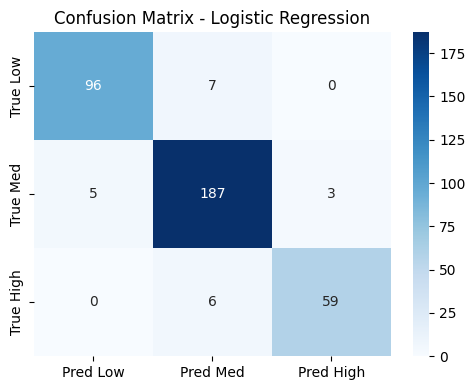


KNN Results:
              precision    recall  f1-score   support

         Low       0.59      0.56      0.57       103
      Medium       0.69      0.70      0.69       195
        High       0.43      0.45      0.44        65

    accuracy                           0.61       363
   macro avg       0.57      0.57      0.57       363
weighted avg       0.61      0.61      0.61       363



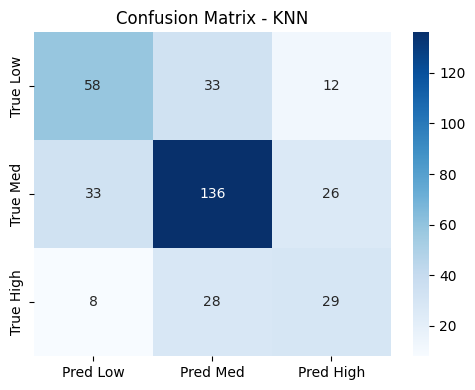


SVC Results:
              precision    recall  f1-score   support

         Low       0.79      0.81      0.80       103
      Medium       0.85      0.86      0.85       195
        High       0.89      0.85      0.87        65

    accuracy                           0.84       363
   macro avg       0.84      0.84      0.84       363
weighted avg       0.84      0.84      0.84       363



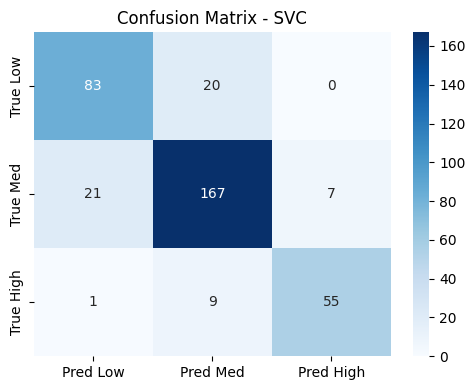


 Model Comparison
                 Model  Macro F1-Score  Accuracy  \
0  Logistic Regression        0.939049  0.942149   
2                  SVC        0.839480  0.840220   
1                  KNN        0.569176  0.614325   

                            Best Params  
0  {'clf__C': 10, 'clf__penalty': 'l2'}  
2  {'clf__C': 10, 'clf__penalty': 'l2'}  
1  {'clf__C': 10, 'clf__penalty': 'l2'}  


In [12]:
X_test = X_test.reindex(columns=X_train.columns).fillna(0)

# Scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define all three models with best hyperparam
models = {
    "Logistic Regression": LogisticRegression(C=1, penalty="l2", multi_class="multinomial", max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights="distance"),
    "SVC": SVC(C=10, kernel="rbf", gamma="scale", decision_function_shape="ovr", random_state=42)
}

results = []

# Evaluate all models 
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Macro F1-Score": macro_f1,
        "Accuracy": acc,
        "Best Params": best_params 
    })
    
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred, target_names=["Low", "Medium", "High"]))
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Pred Low", "Pred Med", "Pred High"],
                yticklabels=["True Low", "True Med", "True High"])
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

# Summary Table 
results_df = pd.DataFrame(results).sort_values(by="Macro F1-Score", ascending=False)
print("\n Model Comparison")
print(results_df)

results_df.to_csv("model_comparison_summary.csv", index=False)

Logistic Regression achieved the highest Macro F1 (0.94) and Accuracy (0.94), indicating it generalized best across all three tax-avoidance classes.
The SVC performed well (Macro F1 ≈ 0.84) but was slightly less consistent, while KNN lagged behind due to its sensitivity to feature scaling and high-dimensional data.
Overall, the confusion matrices show that Logistic Regression made few misclassifications and balanced precision–recall effectively across “Low”, “Medium”, and “High” tax-avoidance firms.

### Save to pickle

In [13]:
results_df

,Model,Macro F1-Score,Accuracy,Best Params
0,Logistic Regression,0.939049,0.942149,"{'clf__C': 10, 'clf__penalty': 'l2'}"
2,SVC,0.839480,0.840220,"{'clf__C': 10, 'clf__penalty': 'l2'}"
1,KNN,0.569176,0.614325,"{'clf__C': 10, 'clf__penalty': 'l2'}"


In [14]:
import pickle

In [15]:
res = results_df.sort_values("Macro F1-Score", ascending=False).reset_index(drop=True)
best_model_name = res.loc[0, "Model"]
best_params = ast.literal_eval(res.loc[0, "Best Params"]) if isinstance(res.loc[0, "Best Params"], str) else res.loc[0, "Best Params"]
print("Winner:", best_model_name, best_params)

# 2) Rebuild the exact pipeline for the winner
def make_pipeline(name):
    if name == "Logistic Regression":
        return Pipeline([("scaler", StandardScaler()),
                         ("clf", LogisticRegression(multi_class="multinomial", max_iter=2000, random_state=42))])
    if name == "K-Nearest Neighbors":
        return Pipeline([("scaler", StandardScaler()),
                         ("clf", KNeighborsClassifier())])
    if name == "Support Vector Classifier":
        return Pipeline([("scaler", StandardScaler()),
                         ("clf", SVC(decision_function_shape="ovr", random_state=42))])
    raise ValueError(name)

best_pipeline = make_pipeline(best_model_name)
best_pipeline.set_params(**best_params)

best_pipeline.fit(X_train, y_train)


os.makedirs("models", exist_ok=True)
with open("models/best_pipeline.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)


with open("models/best_model.pkl", "wb") as f:
    pickle.dump(best_pipeline.named_steps["clf"], f)
with open("models/scaler.pkl", "wb") as f:
    pickle.dump(best_pipeline.named_steps["scaler"], f)



Winner: Logistic Regression {'clf__C': 10, 'clf__penalty': 'l2'}


c:\Users\agata\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [16]:
with open("models/best_pipeline.pkl", "rb") as f:
    p = pickle.load(f)
print("Best model:", p.named_steps["clf"]) 

Best model: LogisticRegression(C=10, max_iter=2000, multi_class='multinomial',
                   random_state=42)
